# ResNet50 Furniture Classification Experiments

This notebook trains ResNet50 on furniture profitability classification with three data configurations:
- **all**: All data in dataset
- **high_quality**: High confidence predictions (≥0.8 confidence score for any tabular column)
- **brand_msrp_only**: Only listings with known brand and MSRP data

In [2]:
# Login to HuggingFace to access private dataset
from huggingface_hub import login
login()

In [ ]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pathlib import Path

from image_only.dataset_utils import load_and_split_hf_data, get_hf_data_loaders, DATASET_REPO
from image_only.training_utils import (
    train_model, evaluate_model, plot_training_history, 
    plot_confusion_matrix, visualize_misclassified,
    save_experiment_results, print_experiment_summary
)

# Set random seeds for reproducability across experiments
torch.manual_seed(42)
np.random.seed(42)

# Device config
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using device: CUDA - {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print(f"Using device: CPU")

# Paths
RESULTS_DIR = Path('results/resnet50')
MODELS_DIR = Path('models/resnet50')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using HuggingFace dataset: {DATASET_REPO}")

Using device: CUDA - Tesla V100-SXM2-16GB
Using HuggingFace dataset: adybacki/furniture-profitability-dataset


## Data Transforms

In [4]:
# ResNet50 expects 224x224 images with ImageNet normalization
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

## Model Definition

In [5]:
def create_resnet50_model():
    """
    Create ResNet50 model for binary classification
    """
    # Load pre-trained ResNet50
    model = models.resnet50(pretrained=True)
    

    for param in model.parameters():
        param.requires_grad = False

    # ResNet50 outputs 2048 features (already pooled)
    num_features = model.fc.in_features  # 2048
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 2)
    )
    
    return model

## Training Configuration

In [6]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001

# Data modes to test
DATA_MODES = ['all', 'high_quality', 'brand_msrp_only']

## Experiment Loop

Run experiments for all three data configurations


EXPERIMENT: ResNet50 with ALL data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: all
26,554 samples after filtering

Original class distribution: {0: 18078, 1: 8476}
Balancing classes to 8476 samples each...
Balanced class distribution: {0: 8476, 1: 8476}

Train samples: 13561
Validation samples: 1695
Test samples: 1696
Dataset initialized with 13561 samples
Class distribution: {1: 6781, 0: 6780}
Dataset initialized with 1695 samples
Class distribution: {0: 848, 1: 847}
Dataset initialized with 1696 samples
Class distribution: {0: 848, 1: 848}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /usr4/ds340/adybacki/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 269MB/s]



Training resnet50_all



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 71.23s
────────────────────────────────────────────────────────────
Train - Loss: 0.6951 | Acc: 0.5209 | F1: 0.5158
Val   - Loss: 0.6868 | Acc: 0.5522 | F1: 0.6281
New best model saved (F1: 0.6281)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 71.32s
────────────────────────────────────────────────────────────
Train - Loss: 0.6912 | Acc: 0.5250 | F1: 0.5164
Val   - Loss: 0.6908 | Acc: 0.5127 | F1: 0.6677
New best model saved (F1: 0.6677)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 71.05s
────────────────────────────────────────────────────────────
Train - Loss: 0.6864 | Acc: 0.5494 | F1: 0.5582
Val   - Loss: 0.6817 | Acc: 0.5581 | F1: 0.6380
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 71.36s
────────────────────────────────────────────────────────────
Train - Loss: 0.6828 | Acc: 0.5624 | F1: 0.5626
Val   - Loss: 0.6790 | Acc: 0.5764 | F1: 0.5562
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 71.75s
────────────────────────────────────────────────────────────
Train - Loss: 0.6831 | Acc: 0.5605 | F1: 0.5561
Val   - Loss: 0.6773 | Acc: 0.5687 | F1: 0.6302
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 72.01s
────────────────────────────────────────────────────────────
Train - Loss: 0.6811 | Acc: 0.5651 | F1: 0.5650
Val   - Loss: 0.6768 | Acc: 0.5782 | F1: 0.6297
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 71.51s
────────────────────────────────────────────────────────────
Train - Loss: 0.6787 | Acc: 0.5667 | F1: 0.5691
Val   - Loss: 0.6766 | Acc: 0.5735 | F1: 0.4266
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 73.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.6784 | Acc: 0.5714 | F1: 0.5696
Val   - Loss: 0.6727 | Acc: 0.5888 | F1: 0.5789
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 73.25s
────────────────────────────────────────────────────────────
Train - Loss: 0.6768 | Acc: 0.5703 | F1: 0.5751
Val   - Loss: 0.6759 | Acc: 0.5652 | F1: 0.5698
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 71.65s
────────────────────────────────────────────────────────────
Train - Loss: 0.6780 | Acc: 0.5695 | F1: 0.5736
Val   - Loss: 0.6728 | Acc: 0.5764 | F1: 0.5579
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 71.40s
────────────────────────────────────────────────────────────
Train - Loss: 0.6794 | Acc: 0.5720 | F1: 0.5699
Val   - Loss: 0.6761 | Acc: 0.5758 | F1: 0.4662
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 71.47s
────────────────────────────────────────────────────────────
Train - Loss: 0.6753 | Acc: 0.5762 | F1: 0.5740
Val   - Loss: 0.6728 | Acc: 0.5764 | F1: 0.4805
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 71.47s
────────────────────────────────────────────────────────────
Train - Loss: 0.6772 | Acc: 0.5746 | F1: 0.5692
Val   - Loss: 0.6692 | Acc: 0.5923 | F1: 0.5875
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 72.91s
────────────────────────────────────────────────────────────
Train - Loss: 0.6762 | Acc: 0.5713 | F1: 0.5770
Val   - Loss: 0.6691 | Acc: 0.5912 | F1: 0.5578
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 73.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.6748 | Acc: 0.5786 | F1: 0.5799
Val   - Loss: 0.6739 | Acc: 0.5705 | F1: 0.6452
────────────────────────────────────────────────────────────

TRAINING COMPLETE - resnet50_all
Best Validation F1: 0.6677
Total Epochs: 15


EXPERIMENT SUMMARY
Model: ResNet50
Data Mode: all

Test Set Performance:
  Accuracy:  0.5212
  F1 Score:  0.6728
  Precision: 0.5110
  Recall:    0.9847



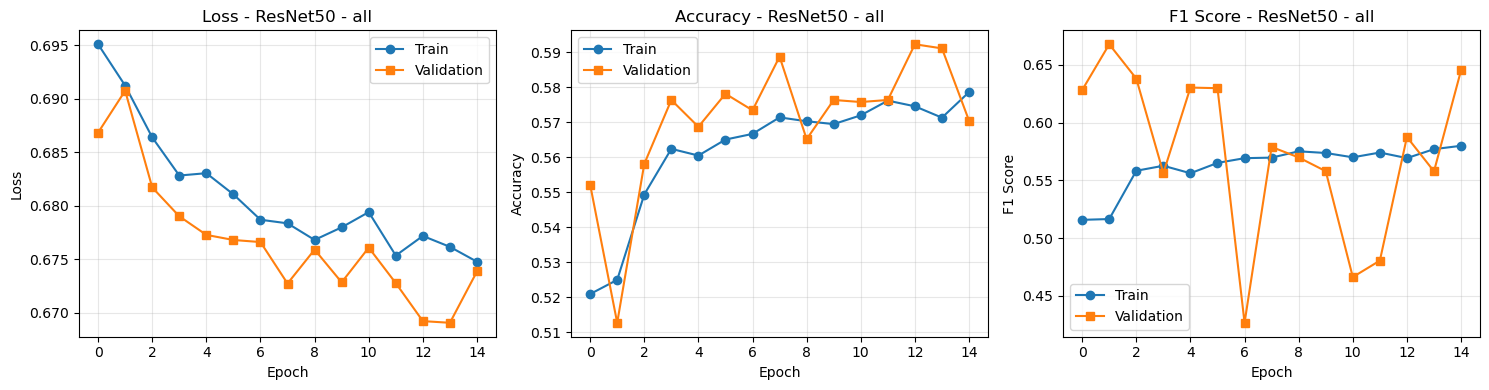

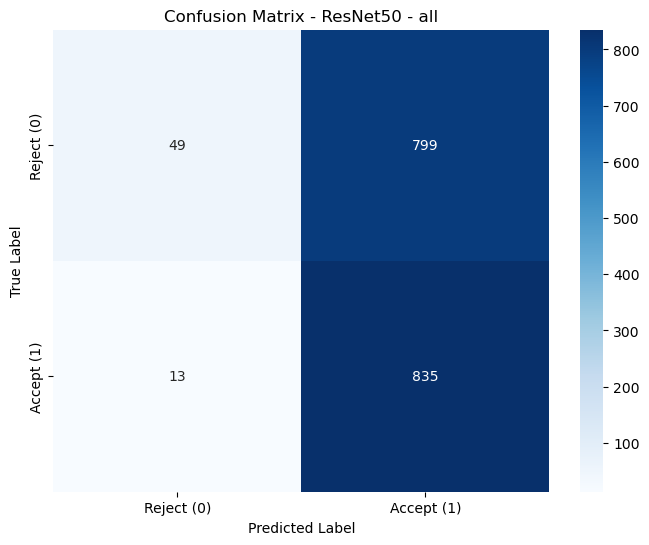


Analyzing misclassified examples...


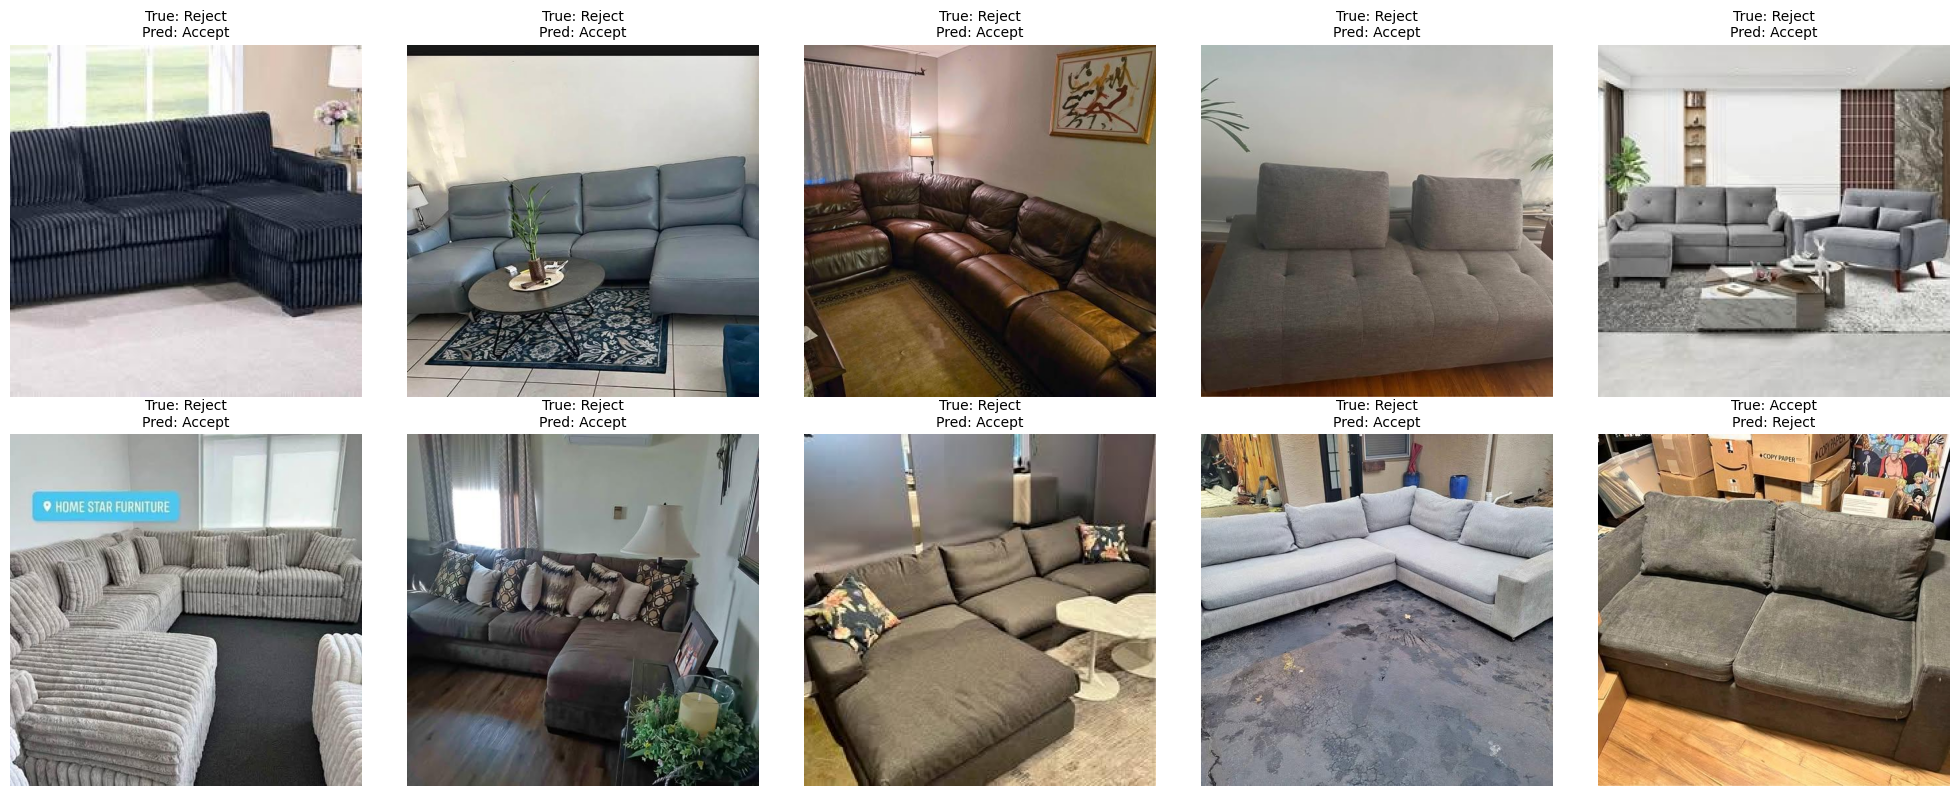

Results saved to results/resnet50/resnet50_all_results.json

EXPERIMENT: ResNet50 with HIGH_QUALITY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: high_quality
12,846 samples after filtering

Original class distribution: {0: 6437, 1: 6409}

Train samples: 10276
Validation samples: 1285
Test samples: 1285
Dataset initialized with 10276 samples
Class distribution: {0: 5149, 1: 5127}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training resnet50_high_quality



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 55.33s
────────────────────────────────────────────────────────────
Train - Loss: 0.6958 | Acc: 0.5279 | F1: 0.5224
Val   - Loss: 0.6849 | Acc: 0.5424 | F1: 0.2557
New best model saved (F1: 0.2557)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 54.42s
────────────────────────────────────────────────────────────
Train - Loss: 0.6863 | Acc: 0.5478 | F1: 0.5446
Val   - Loss: 0.6754 | Acc: 0.5759 | F1: 0.5725
New best model saved (F1: 0.5725)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 54.48s
────────────────────────────────────────────────────────────
Train - Loss: 0.6821 | Acc: 0.5583 | F1: 0.5599
Val   - Loss: 0.6764 | Acc: 0.5712 | F1: 0.6667
New best model saved (F1: 0.6667)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 54.39s
────────────────────────────────────────────────────────────
Train - Loss: 0.6810 | Acc: 0.5600 | F1: 0.5677
Val   - Loss: 0.6795 | Acc: 0.5572 | F1: 0.6655
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 54.04s
────────────────────────────────────────────────────────────
Train - Loss: 0.6768 | Acc: 0.5708 | F1: 0.5774
Val   - Loss: 0.6696 | Acc: 0.5907 | F1: 0.5660
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 53.69s
────────────────────────────────────────────────────────────
Train - Loss: 0.6754 | Acc: 0.5701 | F1: 0.5716
Val   - Loss: 0.6700 | Acc: 0.6008 | F1: 0.6122
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 54.31s
────────────────────────────────────────────────────────────
Train - Loss: 0.6733 | Acc: 0.5789 | F1: 0.5853
Val   - Loss: 0.6682 | Acc: 0.5860 | F1: 0.6295
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 54.53s
────────────────────────────────────────────────────────────
Train - Loss: 0.6735 | Acc: 0.5782 | F1: 0.5940
Val   - Loss: 0.6685 | Acc: 0.5953 | F1: 0.6477
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 54.49s
────────────────────────────────────────────────────────────
Train - Loss: 0.6711 | Acc: 0.5806 | F1: 0.5862
Val   - Loss: 0.6631 | Acc: 0.5860 | F1: 0.6563
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 54.18s
────────────────────────────────────────────────────────────
Train - Loss: 0.6722 | Acc: 0.5793 | F1: 0.5920
Val   - Loss: 0.6655 | Acc: 0.6062 | F1: 0.6609
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 54.28s
────────────────────────────────────────────────────────────
Train - Loss: 0.6676 | Acc: 0.5889 | F1: 0.5976
Val   - Loss: 0.6708 | Acc: 0.5821 | F1: 0.6747
New best model saved (F1: 0.6747)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 54.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.6684 | Acc: 0.5876 | F1: 0.6036
Val   - Loss: 0.6650 | Acc: 0.6023 | F1: 0.5829
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 54.45s
────────────────────────────────────────────────────────────
Train - Loss: 0.6672 | Acc: 0.5859 | F1: 0.5948
Val   - Loss: 0.6596 | Acc: 0.6241 | F1: 0.6523
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 54.67s
────────────────────────────────────────────────────────────
Train - Loss: 0.6679 | Acc: 0.5864 | F1: 0.6007
Val   - Loss: 0.6565 | Acc: 0.6358 | F1: 0.6513
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 54.86s
────────────────────────────────────────────────────────────
Train - Loss: 0.6640 | Acc: 0.5957 | F1: 0.6064
Val   - Loss: 0.6566 | Acc: 0.5961 | F1: 0.6198
────────────────────────────────────────────────────────────

TRAINING COMPLETE - resnet50_high_quality
Best Validation F1: 0.6747
Total Epochs: 15


EXPERIMENT SUMMARY
Model: ResNet50
Data Mode: high_quality

Test Set Performance:
  Accuracy:  0.5790
  F1 Score:  0.6762
  Precision: 0.5485
  Recall:    0.8814



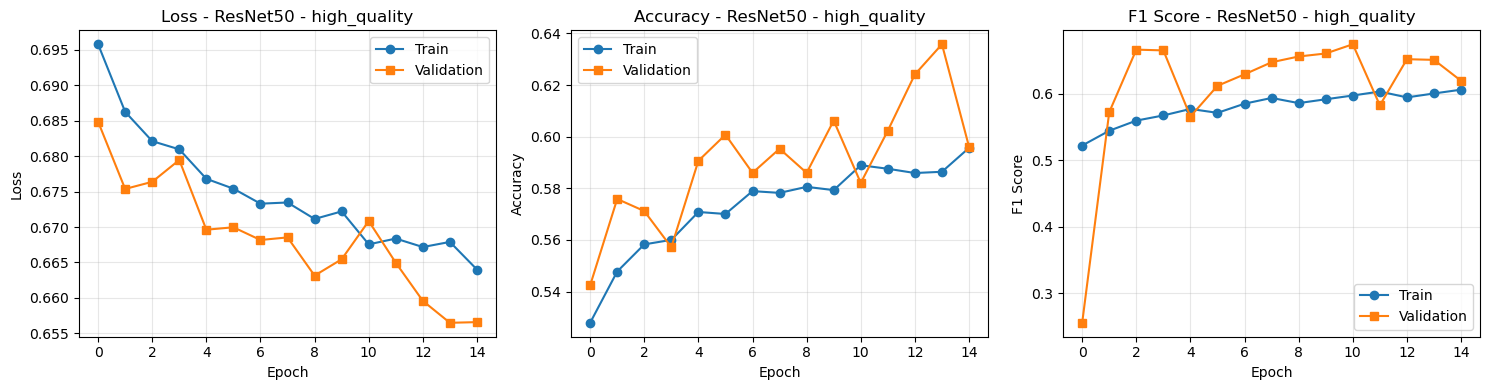

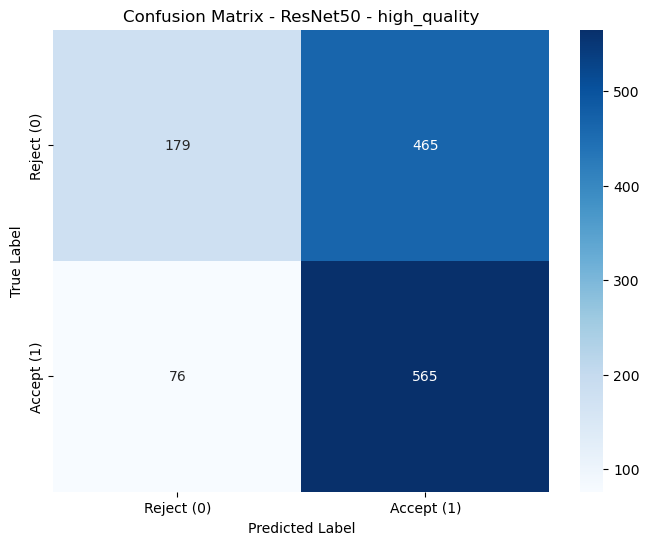


Analyzing misclassified examples...


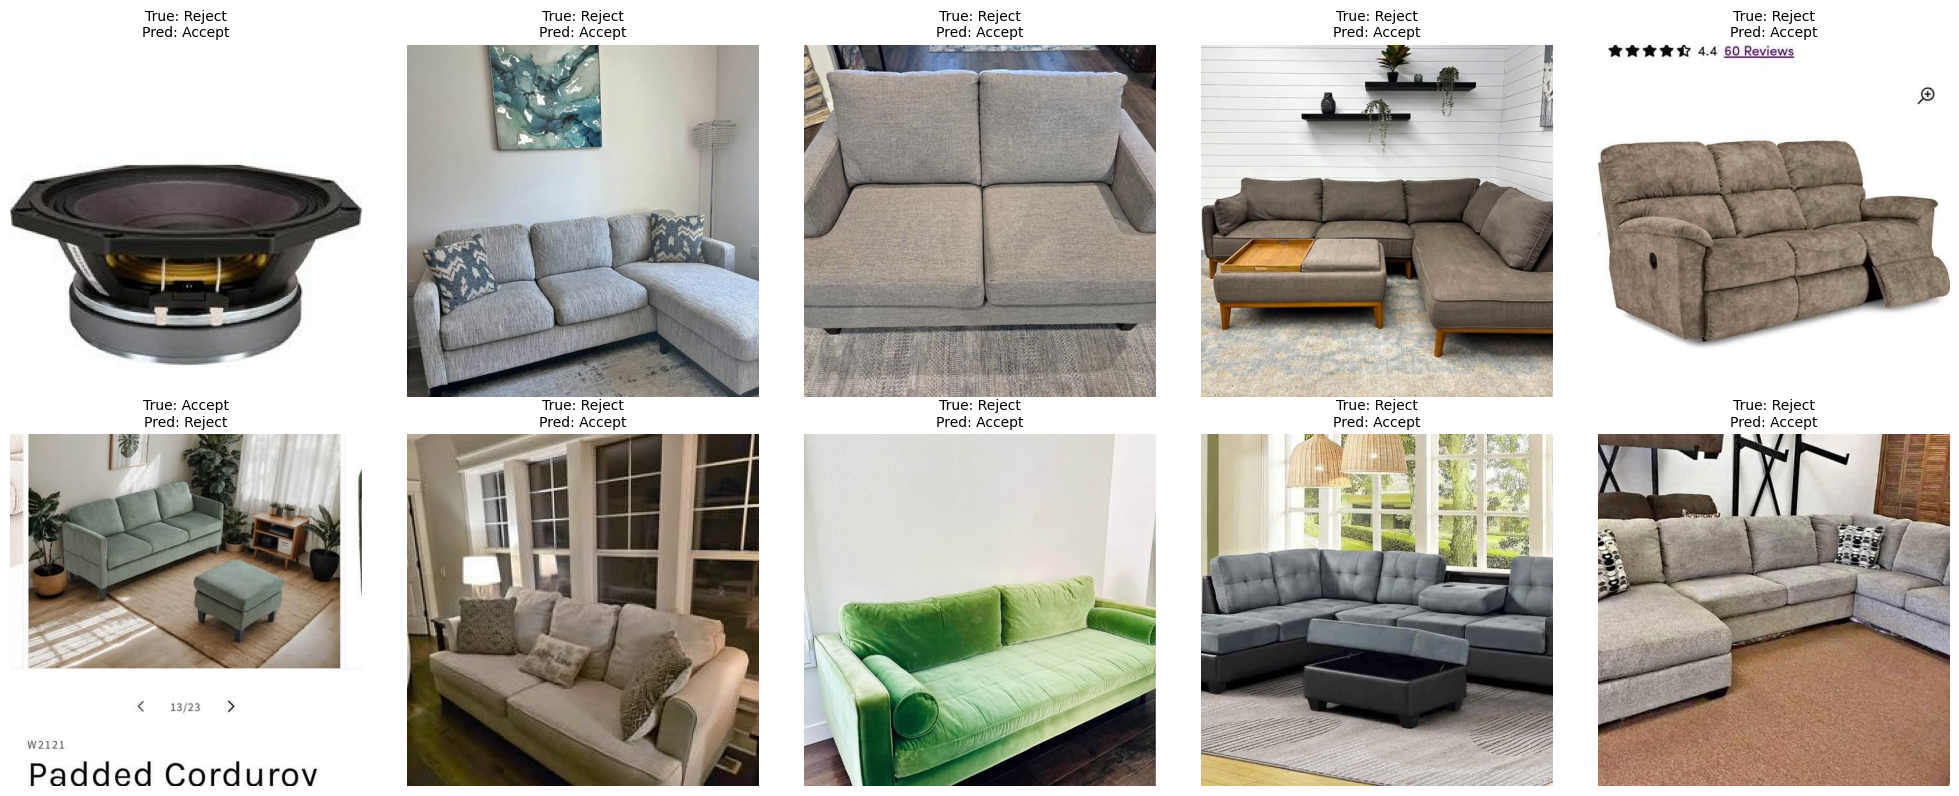

Results saved to results/resnet50/resnet50_high_quality_results.json

EXPERIMENT: ResNet50 with BRAND_MSRP_ONLY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: brand_msrp_only
5,209 samples after filtering

Original class distribution: {1: 3499, 0: 1710}
Balancing classes to 1710 samples each...
Balanced class distribution: {1: 1710, 0: 1710}

Train samples: 2736
Validation samples: 342
Test samples: 342
Dataset initialized with 2736 samples
Class distribution: {0: 1368, 1: 1368}
Dataset initialized with 342 samples
Class distribution: {0: 171, 1: 171}
Dataset initialized with 342 samples
Class distribution: {1: 171, 0: 171}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training resnet50_brand_msrp_only


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 15.44s
────────────────────────────────────────────────────────────
Train - Loss: 0.7034 | Acc: 0.5033 | F1: 0.5127
Val   - Loss: 0.6938 | Acc: 0.5000 | F1: 0.0000
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 14.42s
────────────────────────────────────────────────────────────
Train - Loss: 0.6884 | Acc: 0.5402 | F1: 0.5445
Val   - Loss: 0.6774 | Acc: 0.5906 | F1: 0.5679
New best model saved (F1: 0.5679)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 14.54s
────────────────────────────────────────────────────────────
Train - Loss: 0.6813 | Acc: 0.5632 | F1: 0.5506
Val   - Loss: 0.6677 | Acc: 0.6199 | F1: 0.6084
New best model saved (F1: 0.6084)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 14.57s
────────────────────────────────────────────────────────────
Train - Loss: 0.6736 | Acc: 0.5859 | F1: 0.5881
Val   - Loss: 0.6662 | Acc: 0.6228 | F1: 0.6596
New best model saved (F1: 0.6596)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 14.56s
────────────────────────────────────────────────────────────
Train - Loss: 0.6762 | Acc: 0.5742 | F1: 0.5718
Val   - Loss: 0.6635 | Acc: 0.6287 | F1: 0.6577
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 14.61s
────────────────────────────────────────────────────────────
Train - Loss: 0.6700 | Acc: 0.5815 | F1: 0.5886
Val   - Loss: 0.6600 | Acc: 0.6316 | F1: 0.6135
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 14.58s
────────────────────────────────────────────────────────────
Train - Loss: 0.6681 | Acc: 0.5917 | F1: 0.5892
Val   - Loss: 0.6505 | Acc: 0.6520 | F1: 0.6704
New best model saved (F1: 0.6704)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 14.86s
────────────────────────────────────────────────────────────
Train - Loss: 0.6678 | Acc: 0.5866 | F1: 0.6008
Val   - Loss: 0.6538 | Acc: 0.6550 | F1: 0.6570
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 14.94s
────────────────────────────────────────────────────────────
Train - Loss: 0.6596 | Acc: 0.6078 | F1: 0.6122
Val   - Loss: 0.6567 | Acc: 0.6228 | F1: 0.6172
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 14.86s
────────────────────────────────────────────────────────────
Train - Loss: 0.6571 | Acc: 0.6078 | F1: 0.6100
Val   - Loss: 0.6498 | Acc: 0.6550 | F1: 0.6509
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 14.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.6592 | Acc: 0.5994 | F1: 0.6055
Val   - Loss: 0.6493 | Acc: 0.6053 | F1: 0.5921
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 14.83s
────────────────────────────────────────────────────────────
Train - Loss: 0.6560 | Acc: 0.6045 | F1: 0.6054
Val   - Loss: 0.6504 | Acc: 0.6228 | F1: 0.6560
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 14.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.6512 | Acc: 0.6239 | F1: 0.6254
Val   - Loss: 0.6438 | Acc: 0.6374 | F1: 0.6737
New best model saved (F1: 0.6737)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 14.83s
────────────────────────────────────────────────────────────
Train - Loss: 0.6538 | Acc: 0.6148 | F1: 0.6189
Val   - Loss: 0.6468 | Acc: 0.6520 | F1: 0.7003
New best model saved (F1: 0.7003)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 14.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.6488 | Acc: 0.6246 | F1: 0.6294
Val   - Loss: 0.6515 | Acc: 0.6257 | F1: 0.6800
────────────────────────────────────────────────────────────

TRAINING COMPLETE - resnet50_brand_msrp_only
Best Validation F1: 0.7003
Total Epochs: 15


EXPERIMENT SUMMARY
Model: ResNet50
Data Mode: brand_msrp_only

Test Set Performance:
  Accuracy:  0.6520
  F1 Score:  0.6877
  Precision: 0.6238
  Recall:    0.7661



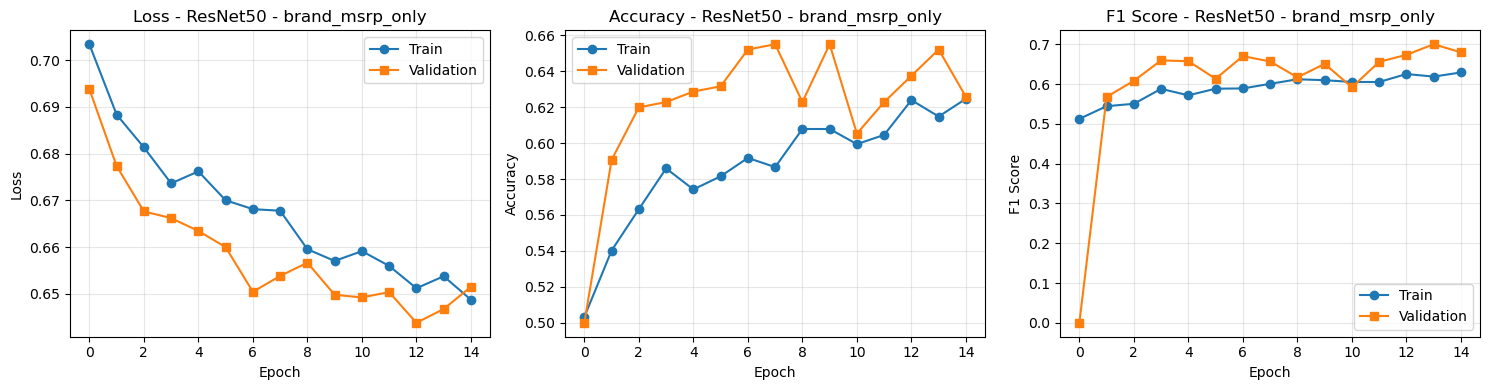

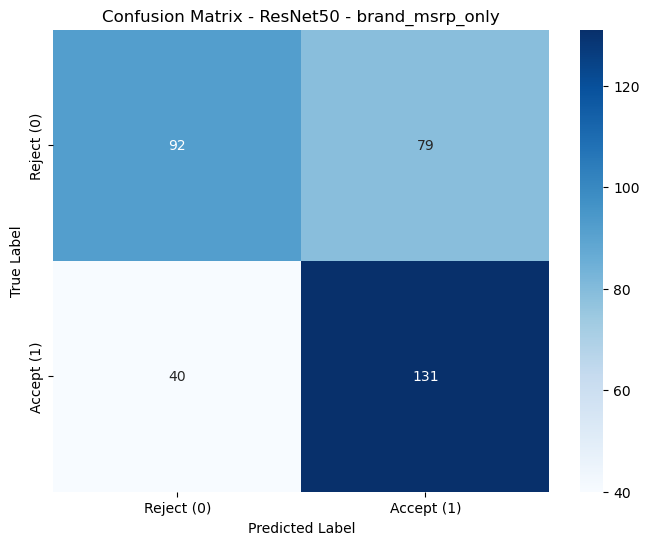


Analyzing misclassified examples...


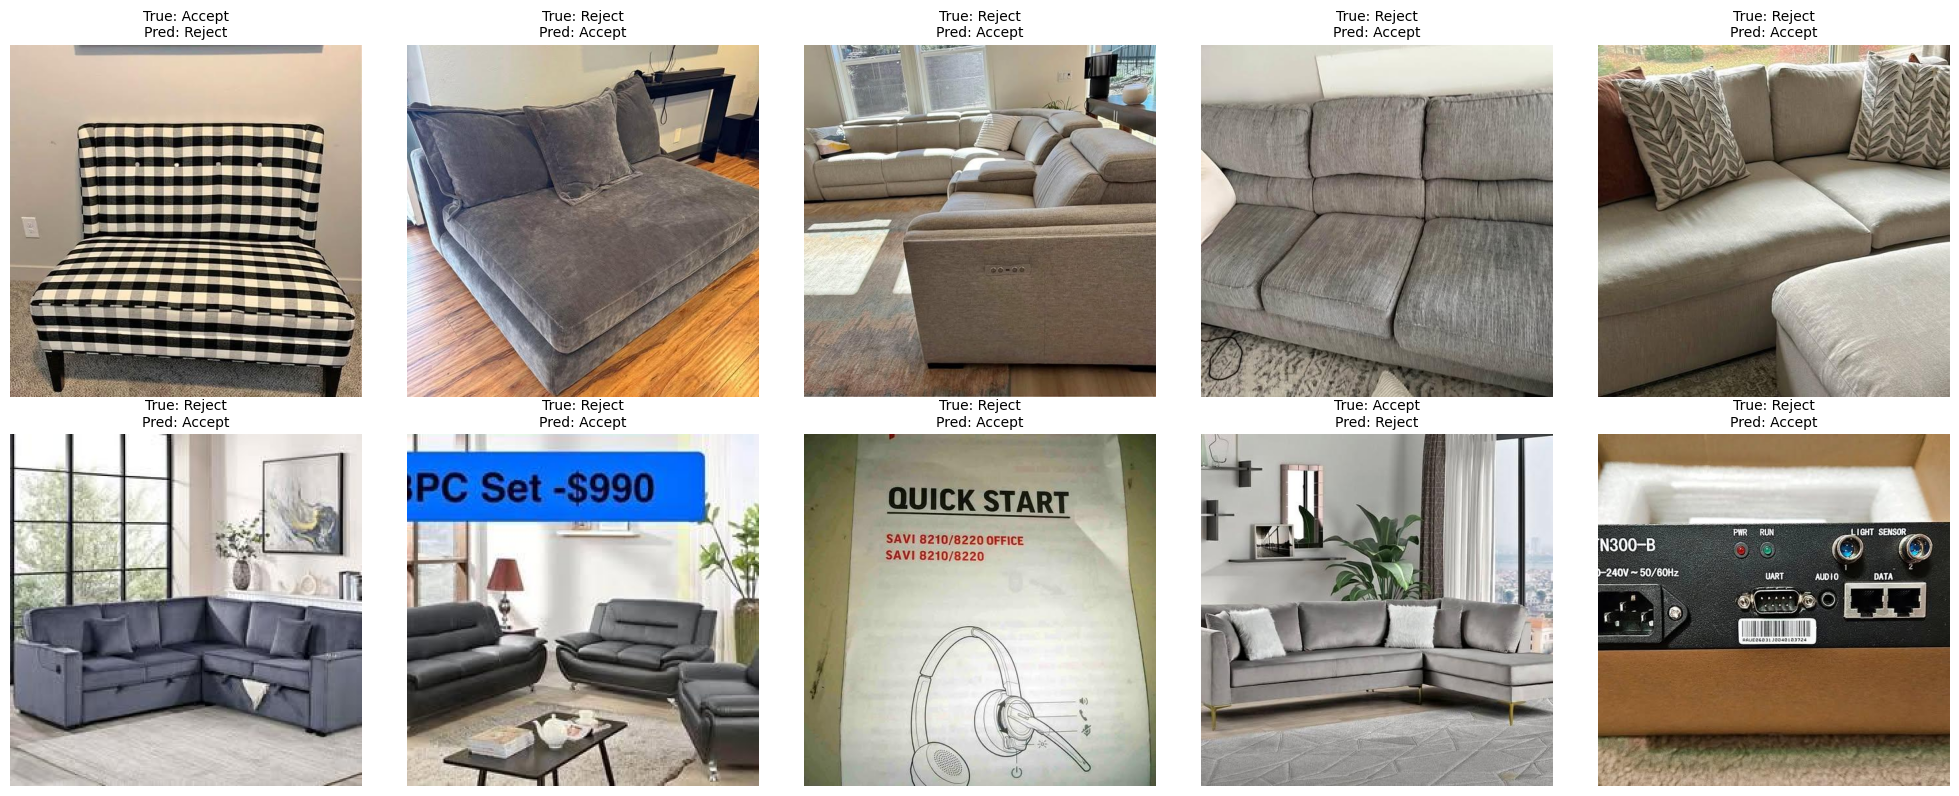

Results saved to results/resnet50/resnet50_brand_msrp_only_results.json


In [7]:
all_results = {}

for data_mode in DATA_MODES:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: ResNet50 with {data_mode.upper()} data")
    print(f"{'='*80}\n")
    
    # Load and split data from HuggingFace
    train_idx, val_idx, test_idx, hf_dataset = load_and_split_hf_data(
        DATASET_REPO,
        data_mode=data_mode,
        test_size=0.2,
        random_state=42
    )
    
    # Create data loaders
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_hf_data_loaders(
        train_idx, val_idx, test_idx, hf_dataset,
        transform, transform,
        batch_size=BATCH_SIZE
    )
    
    # Create model
    model = create_resnet50_model()
    model = model.to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
    
    # Train model
    model_name = f"resnet50_{data_mode}"
    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        DEVICE, NUM_EPOCHS, model_name, save_dir=MODELS_DIR
    )
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(MODELS_DIR / f"{model_name}_best.pth"))
    
    # Evaluate on test set
    test_results = evaluate_model(model, test_loader, criterion, DEVICE)
    
    # Store results
    all_results[data_mode] = {
        'model_name': 'ResNet50',
        'data_mode': data_mode,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'test_accuracy': test_results['accuracy'],
        'test_f1': test_results['f1'],
        'test_precision': test_results['precision'],
        'test_recall': test_results['recall'],
        'history': history
    }
    
    # Print summary
    print_experiment_summary(all_results[data_mode])
    
    # Plot training history
    plot_training_history(
        history, 
        f"ResNet50 - {data_mode}",
        save_path=RESULTS_DIR / f"training_history_{data_mode}.png"
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_results['labels'],
        test_results['predictions'],
        f"ResNet50 - {data_mode}",
        save_path=RESULTS_DIR / f"confusion_matrix_{data_mode}.png"
    )
    
    # Visualize misclassified examples
    print("\nAnalyzing misclassified examples...")
    visualize_misclassified(
        model, test_dataset, DEVICE, 
        num_examples=10,
        save_path=RESULTS_DIR / f"misclassified_{data_mode}.png"
    )
    
    # Save results
    save_experiment_results(
        all_results[data_mode],
        f"resnet50_{data_mode}",
        save_dir=RESULTS_DIR
    )

## Compare Results Across Data Modes


RESNET50 RESULTS COMPARISON
      Data Mode  Train Size  Test Accuracy  Test F1  Test Precision  Test Recall
            All       13561       0.521226 0.672844        0.511016     0.984670
   High Quality       10276       0.578988 0.676242        0.548544     0.881435
Brand Msrp Only        2736       0.652047 0.687664        0.623810     0.766082



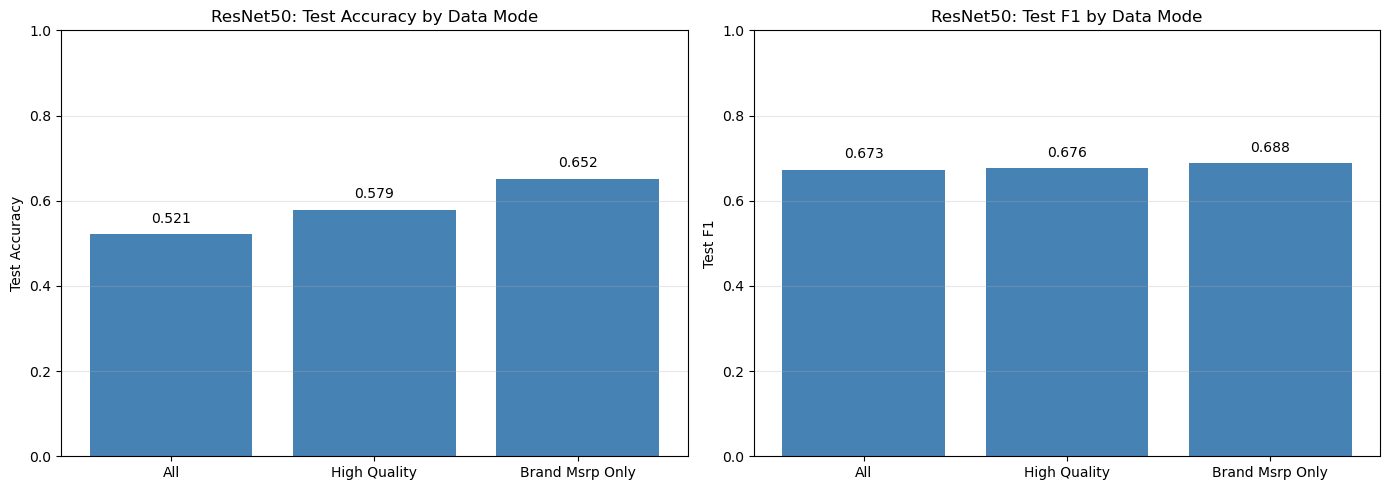

In [8]:
import matplotlib.pyplot as plt

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Data Mode': mode.replace('_', ' ').title(),
        'Train Size': results['train_samples'],
        'Test Accuracy': results['test_accuracy'],
        'Test F1': results['test_f1'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall']
    }
    for mode, results in all_results.items()
])

print("\n" + "="*80)
print("RESNET50 RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Test Accuracy', 'Test F1']
for ax, metric in zip(axes, metrics):
    ax.bar(comparison_df['Data Mode'], comparison_df[metric], color='steelblue')
    ax.set_ylabel(metric)
    ax.set_title(f'ResNet50: {metric} by Data Mode')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet50_comparison.png', dpi=300, bbox_inches='tight')
plt.show()